Inspiration:http://toddwschneider.com/posts/a-tale-of-twenty-two-million-citi-bikes-analyzing-the-nyc-bike-share-system/
Data links: 
1) cycle hire data: http://cycling.data.tfl.gov.uk/
2) locations lat lon: https://api-portal.tfl.gov.uk/docs
3) weather data
4) optional - demographic or economic data

EDA phases:
1) Clean up:
y - download csv of 2017 data
y- clean up data and remove unnecessary columns 
download json data of locations of bikes
check if locations match up or any missing locations
2) Aggregates and distributions:
y- big stats - average trip time, total rides, total stations, total bikes
y- stations - distribution of station by ride count, most popular stations to start, most popular stations to end, balancedness score and dist, most disbalanced
y- rides per day distributions - cdf, over time for full year (smoothen/rolling average)
y- rides over time through day by hour - by day of week
rides by hour - violin plot
duration distributions - violin plot by hour of day
duration by hour of day - by day of week
3) network interactions
y- start end pairs dataframe - aggregate up
heatmap/cosine similarity matrix
y- create network with nodes as bike stations
y- understand degrees and plot stations with highest degrees
y- plot of betweenness centrality
visualise network
4) effect of weather:
y- get weather data by hour
y- plot ride data against weather characteristics
5) map visual
map london 
add points based on stations
add color coding based on number of trips


In [101]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

In [324]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import glob
from pandas import Series
import seaborn as sns 
from scipy import stats

In [245]:
path ='2016TripData' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
col_names = ['rental_id','duration','bike_id','end_date','end_station_id','end_station_name','start_date',
             'start_station_id','start_station_name']
df_list = []
cols=list(range(9))
for file_ in allFiles:
    df = pd.read_csv(file_,names=col_names,usecols=cols,header=0,
                     parse_dates=['start_date'],dayfirst=True,infer_datetime_format=True)
    df_list.append(df)

frame=pd.concat(df_list,ignore_index=True)


In [246]:
frame.dtypes

rental_id                      int64
duration                     float64
bike_id                      float64
end_date                      object
end_station_id               float64
end_station_name              object
start_date            datetime64[ns]
start_station_id               int64
start_station_name            object
dtype: object

In [269]:
frame = frame.dropna(axis=0, how='any')
frame = frame.reset_index(drop=True)
frame.shape

(10348138, 9)

In [258]:
frame.head()

,rental_id,duration,bike_id,end_date,end_station_id,end_station_name,start_date,start_station_id,start_station_name
0,56149114,540.0,870.0,20/07/2016 00:09,163.0,"Sloane Avenue, Knightsbridge",2016-07-20,222,"Knightsbridge, Hyde Park"
1,56149118,480.0,8772.0,20/07/2016 00:08,28.0,"Bolsover Street, Fitzrovia",2016-07-20,271,"London Zoo, The Regent's Park"
2,56149133,1320.0,5247.0,20/07/2016 00:22,22.0,"Northington Street , Holborn",2016-07-20,348,"Grosvenor Square, Mayfair"
3,56149134,600.0,3926.0,20/07/2016 00:10,61.0,"Great Dover Street, The Borough",2016-07-20,154,"Waterloo Station 3, Waterloo"
4,56149117,480.0,2038.0,20/07/2016 00:08,721.0,"Wendon Street, Old Ford",2016-07-20,492,"The Green Bridge, Mile End"


In [252]:
#big stats - average trip time, total rides, total stations, total bikes
#rides
print(frame.shape[0])
#avg duration
print(round(frame['duration'].mean()/60))
#no. of unique stations
df_try = [frame['end_station_name'],frame['start_station_name']]
df_stations = pd.concat(df_try)
print(df_stations.nunique())
#no. of bikes 
print(frame['bike_id'].nunique())


10348138
21
807
12958


stations - distribution of station by ride count, most popular stations to start, most popular stations to end, balancedness score and dist, most disbalanced

In [259]:
start_station_counts = frame.groupby(['start_station_name']).size().reset_index(name='counts')
start_station_counts=start_station_counts.sort_values(by=['counts'],ascending=False)
end_station_counts = frame.groupby(['end_station_name']).size().reset_index(name='counts')
end_station_counts=end_station_counts.sort_values(by=['counts'],ascending=False)

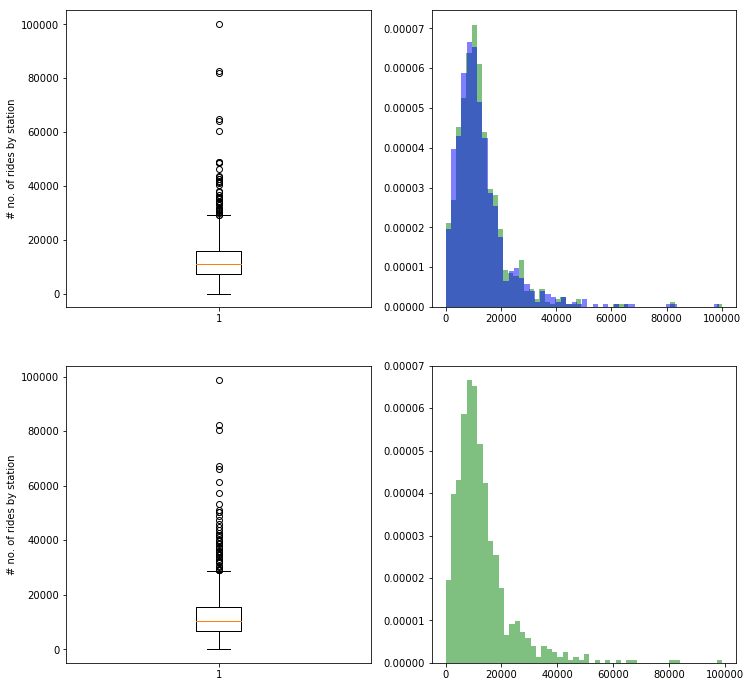

In [261]:
fig, ax = plt.subplots(2,2,figsize=(12, 12))

ax[0][0].boxplot(start_station_counts['counts'])

ax[0][0].set_ylabel('# no. of rides by station')

ax[0][1].hist(start_station_counts['counts'], bins ='auto', normed=1, histtype='stepfilled', facecolor='g', edgecolor='none', alpha=0.5);
ax[0][1].hist(end_station_counts['counts'], bins ='auto', normed=1, histtype='stepfilled', facecolor='b', edgecolor='none', alpha=0.5);

ax[1][0].boxplot(end_station_counts['counts'])

ax[1][0].set_ylabel('# no. of rides by station')

ax[1][1].hist(end_station_counts['counts'], bins ='auto', normed=1, histtype='stepfilled', facecolor='g', edgecolor='none', alpha=0.5);



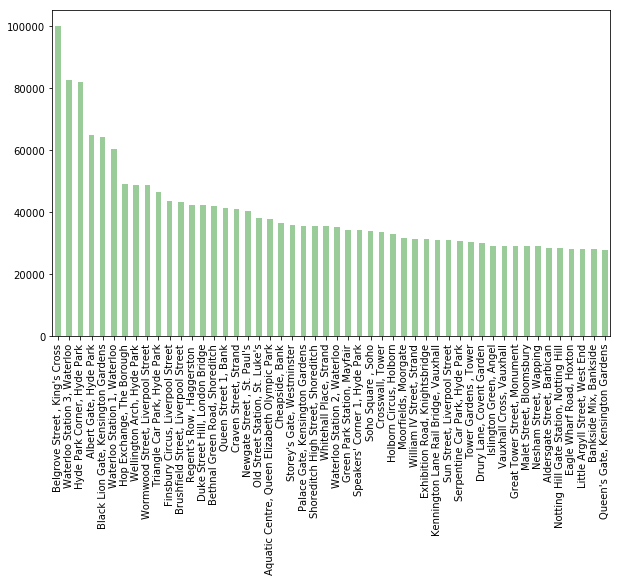

In [262]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = start_station_counts['counts'].head(50).plot(kind='bar', color='g', alpha=0.4)
ax.set_xticklabels(start_station_counts.head(50)['start_station_name']);

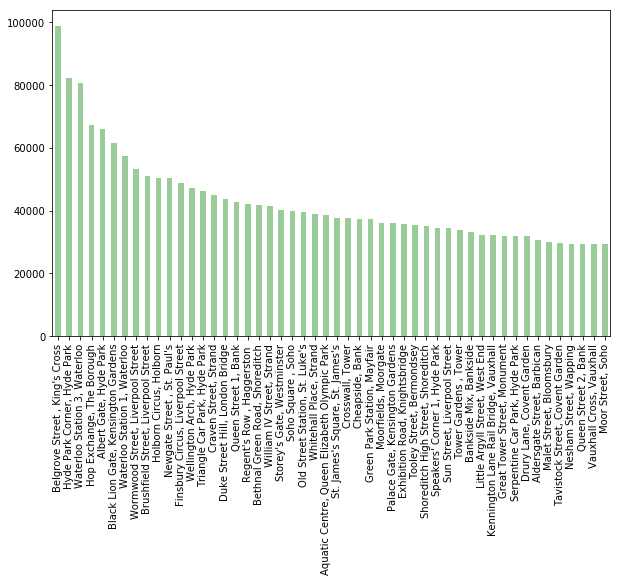

In [263]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = end_station_counts['counts'].head(50).plot(kind='bar', color='g', alpha=0.4)
ax.set_xticklabels(end_station_counts.head(50)['end_station_name']);

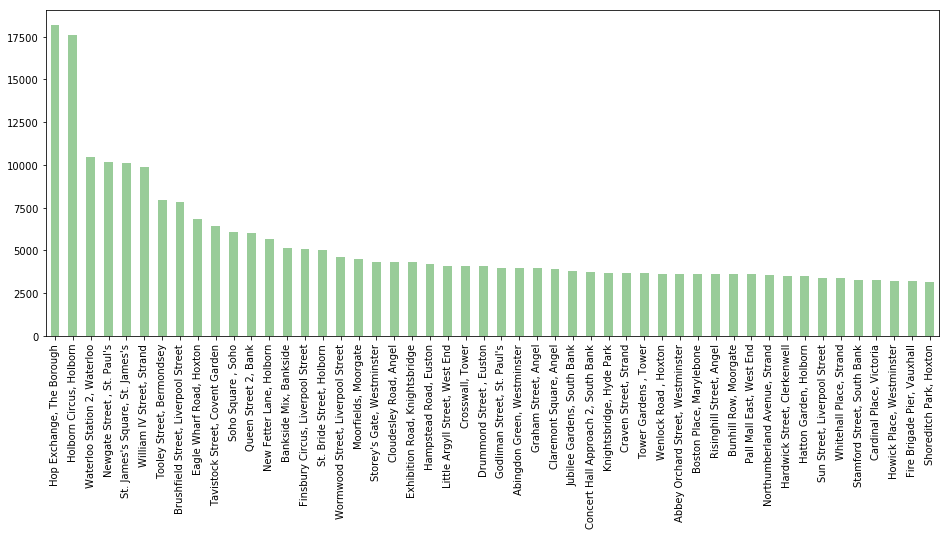

In [264]:
stations_balancedness = pd.merge(end_station_counts, start_station_counts, how='left', left_on='end_station_name', right_on=['start_station_name'])
stations_balancedness = stations_balancedness[['end_station_name','counts_x','counts_y']]
stations_balancedness.fillna(0, inplace=True)
stations_balancedness['balance'] = abs(stations_balancedness['counts_x']-stations_balancedness['counts_y'])
stations_balancedness=stations_balancedness.sort_values(by=['balance'],ascending=False)
fig, ax = plt.subplots(figsize=(16, 6))
ax = stations_balancedness['balance'].head(50).plot(kind='bar', color='g', alpha=0.4)
ax.set_xticklabels(stations_balancedness['end_station_name'].head(50));

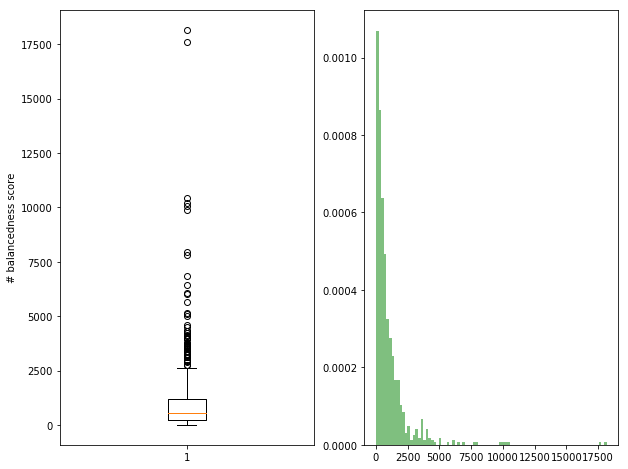

In [265]:
fig, ax = plt.subplots(1,2,figsize=(10, 8))

ax[0].boxplot(stations_balancedness['balance'])

ax[0].set_ylabel('# balancedness score')

ax[1].hist(stations_balancedness['balance'], bins ='auto', normed=1, histtype='stepfilled', facecolor='g', edgecolor='none', alpha=0.5);

rides per day distributions - cdf, over time for full year (smoothen/rolling average)

In [266]:
rides_per_month = frame['start_date']
rides_per_month.index=frame['start_date']
rides_per_month = rides_per_month.resample('M').size().reset_index(name='rides')

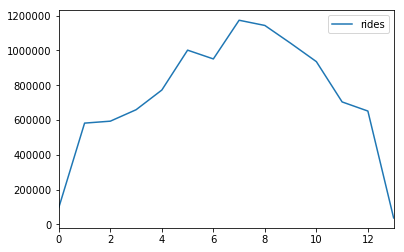

In [267]:
rides_per_month.plot()

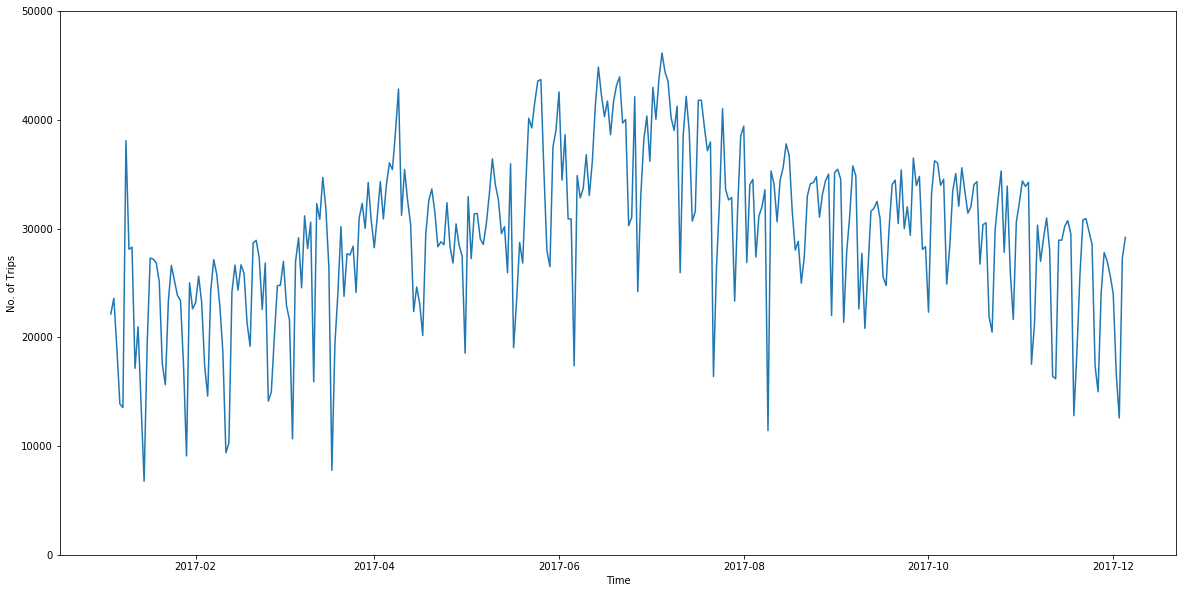

In [83]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(hires_by_day['start_date'],hires_by_day['trips'])
ax.set_xlabel('Time')
ax.set_ylabel('No. of Trips')
ax.set_ylim([0,50000]);

In [270]:
frame['day_of_week'] = frame['start_date'].dt.dayofweek
rides_per_hour = frame[['start_date','day_of_week']]


In [272]:
rides_per_hour['hour']=rides_per_hour['start_date'].dt.hour
rides_per_hour.head()

/Users/sidrajgopalan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,start_date,day_of_week,hour
0,2016-07-20,2,0
1,2016-07-20,2,0
2,2016-07-20,2,0
3,2016-07-20,2,0
4,2016-07-20,2,0


In [273]:
rides_per_hour_week= rides_per_hour.groupby(['hour','day_of_week']).size().unstack()

In [274]:
rides_per_hour_week.head()

day_of_week,0,1,2,3,4,5,6
hour,,,,,,,
0,11068,9067,10391,11125,14863,24031,25802
1,6464,5614,6110,6696,9652,18579,21040
2,3974,3526,3498,4436,6020,13002,14706
3,2700,2365,2411,2830,4168,9051,10469
4,2970,2605,2666,2790,3540,6324,6494


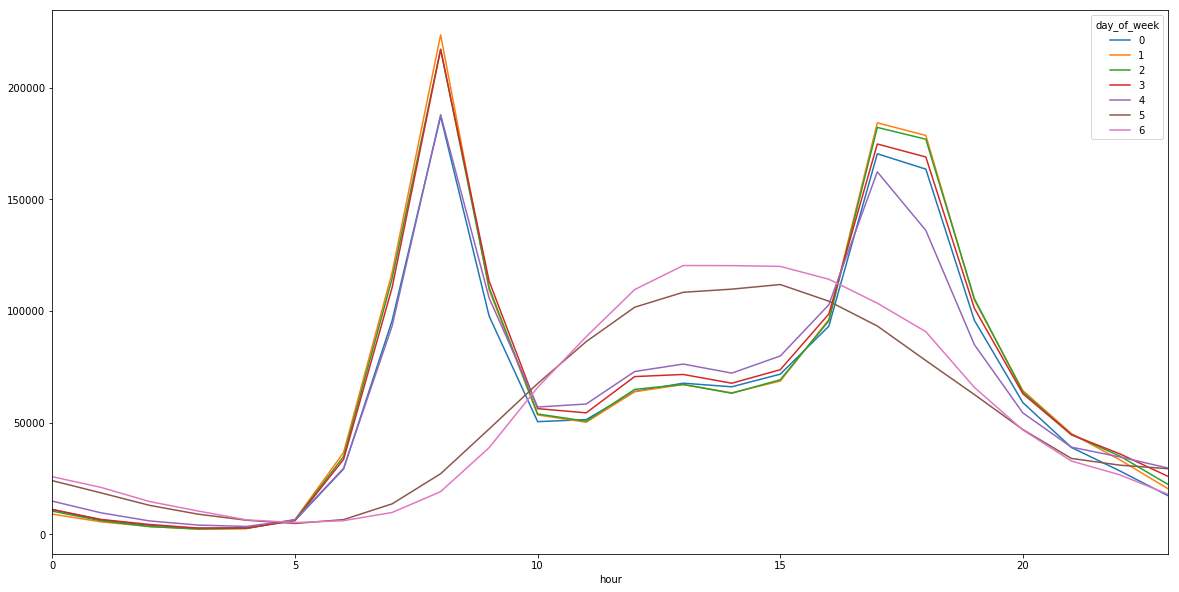

In [275]:
rides_per_hour_week.plot(kind='line',figsize=(20,10))

In [276]:
stations_count = frame.groupby(['start_station_name','end_station_name']).size().reset_index(name='rides')
stations_count.head()

,start_station_name,end_station_name,rides
0,"Abbey Orchard Street, Westminster","Abbey Orchard Street, Westminster",218
1,"Abbey Orchard Street, Westminster","Aberdeen Place, St. John's Wood",4
2,"Abbey Orchard Street, Westminster","Abingdon Green, Westminster",63
3,"Abbey Orchard Street, Westminster","Abingdon Villas, Kensington",2
4,"Abbey Orchard Street, Westminster","Abyssinia Close, Clapham Junction",5


In [277]:
stations_count['rides'].describe()

count    383926.000000
mean         26.953470
std          96.044015
min           1.000000
25%           2.000000
50%           7.000000
75%          24.000000
max       22188.000000
Name: rides, dtype: float64

In [278]:
pair_mx = stations_count.pivot(index='start_station_name',columns='end_station_name',values='rides').fillna(0)

In [280]:
pair_mx.head(10)

end_station_name,"Abbey Orchard Street, Westminster","Abbotsbury Road, Holland Park","Aberdeen Place, St. John's Wood","Aberfeldy Street, Poplar","Abingdon Green, Westminster","Abingdon Villas, Kensington","Abyssinia Close, Clapham Junction","Ackroyd Drive, Bow","Ada Street, Hackney Central","Addison Road, Holland Park",...,"Windsor Terrace, Hoxton","Winsland Street, Paddington","Wood Street, Guildhall","Woodstock Grove, Shepherd's Bush","Woodstock Street, Mayfair","World's End Place, West Chelsea","Wormwood Street, Liverpool Street","Wren Street, Holborn","Wright's Lane, Kensington","York Hall, Bethnal Green"
start_station_name,,,,,,,,,,,,,,,,,,,,,
"Abbey Orchard Street, Westminster",218.0,0.0,4.0,0.0,63.0,2.0,5.0,0.0,2.0,1.0,...,3.0,129.0,1.0,1.0,7.0,9.0,333.0,9.0,15.0,1.0
"Abbotsbury Road, Holland Park",0.0,212.0,2.0,0.0,0.0,35.0,0.0,0.0,0.0,27.0,...,0.0,0.0,0.0,89.0,0.0,1.0,0.0,0.0,94.0,0.0
"Aberdeen Place, St. John's Wood",0.0,0.0,160.0,0.0,3.0,0.0,0.0,1.0,1.0,2.0,...,0.0,33.0,1.0,4.0,9.0,0.0,1.0,4.0,8.0,1.0
"Aberfeldy Street, Poplar",0.0,0.0,0.0,129.0,0.0,0.0,0.0,9.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0
"Abingdon Green, Westminster",81.0,0.0,0.0,0.0,698.0,2.0,33.0,0.0,3.0,0.0,...,6.0,44.0,4.0,1.0,13.0,19.0,144.0,10.0,4.0,1.0
"Abingdon Villas, Kensington",2.0,7.0,2.0,0.0,3.0,195.0,2.0,0.0,0.0,45.0,...,1.0,4.0,0.0,27.0,5.0,17.0,1.0,0.0,1258.0,0.0
"Abyssinia Close, Clapham Junction",1.0,0.0,0.0,0.0,12.0,0.0,228.0,0.0,0.0,0.0,...,0.0,7.0,0.0,1.0,0.0,2.0,4.0,1.0,0.0,0.0
"Ackroyd Drive, Bow",0.0,0.0,0.0,4.0,0.0,0.0,0.0,96.0,10.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,18.0
"Ada Street, Hackney Central",4.0,0.0,0.0,0.0,8.0,0.0,0.0,11.0,219.0,0.0,...,31.0,4.0,6.0,0.0,1.0,0.0,117.0,20.0,0.0,417.0


In [281]:
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(pair_mx)
# the column names are added by converting the array into a data frame
cosine_mx = pd.DataFrame(data=similarities[0:,0:]) 
cosine_mx.head()

,0,1,2,3,4,5,6,7,8,9,...,796,797,798,799,800,801,802,803,804,805
0,1.000000,0.068752,0.139493,0.022937,0.650054,0.074707,0.146269,0.024701,0.160737,0.115530,...,0.190284,0.469338,0.530206,0.031474,0.456062,0.139005,0.353021,0.549774,0.100629,0.048442
1,0.068752,1.000000,0.090749,0.003998,0.073929,0.370048,0.092921,0.001301,0.003480,0.523946,...,0.009585,0.180767,0.019452,0.328795,0.214972,0.148535,0.019153,0.015147,0.382242,0.002239
2,0.139493,0.090749,1.000000,0.005683,0.118185,0.050446,0.051709,0.006923,0.050166,0.111699,...,0.092510,0.414120,0.085572,0.030736,0.330906,0.073228,0.071290,0.105731,0.082305,0.019011
3,0.022937,0.003998,0.005683,1.000000,0.027203,0.001691,0.005686,0.253531,0.150715,0.002707,...,0.112679,0.019316,0.053823,0.002019,0.019808,0.004652,0.098715,0.023162,0.002179,0.132806
4,0.650054,0.073929,0.118185,0.027203,1.000000,0.067518,0.216414,0.024155,0.107068,0.139654,...,0.156619,0.428374,0.326961,0.035996,0.425634,0.204095,0.353205,0.207864,0.114200,0.044659


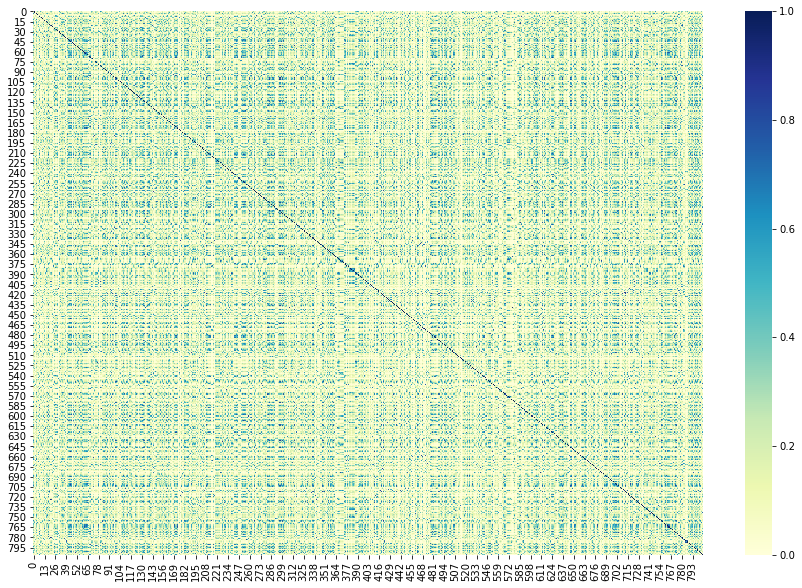

In [282]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(cosine_mx,cmap="YlGnBu")

In [347]:
import networkx as nx
try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either PyGraphviz or pydot")

In [408]:
G = nx.Graph()
stations_count_restricted = stations_count.loc[stations_count['rides'] >= 200]
for index, row in stations_count_restricted.iterrows():
    G.add_edge(row['start_station_name'], row['end_station_name'])
# remove isolated vertices (if any)    
remove = [node for node,degree in G.degree().items() if degree <=10]
G.remove_nodes_from(remove)

In [409]:
# graph size
print("graph has %d nodes with %d edges" % (nx.number_of_nodes(G), nx.number_of_edges(G)))
print(nx.number_connected_components(G), "connected components")

# connected components
gsizes = [nx.number_of_nodes(glen) for glen in nx.connected_component_subgraphs(G)]
print("G connected component sizes:", sorted(gsizes, reverse=True))

graph has 319 nodes with 3048 edges
1 connected components
G connected component sizes: [319]


In [384]:
options = {'node_color': 'lightblue','edge_color': 'lightblue','node_size': 1,'width': 1,'alpha': 1.0}

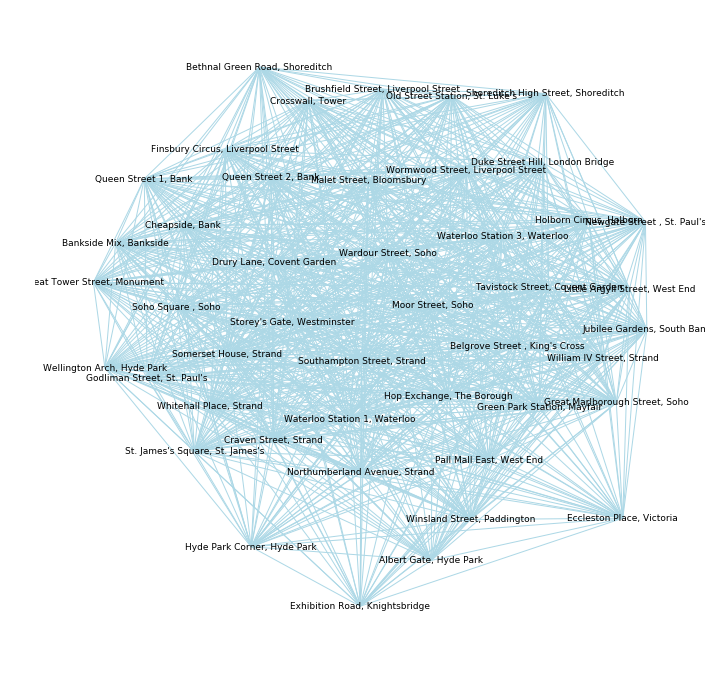

In [385]:
#plot neato
plt.subplots(figsize=(12,12))

pos = graphviz_layout(G, prog="neato")

nx.draw_networkx_edges(G,pos=pos,**options)
nx.draw_networkx_labels(G,pos=pos,font_size=9,**options)

plt.axis('off');

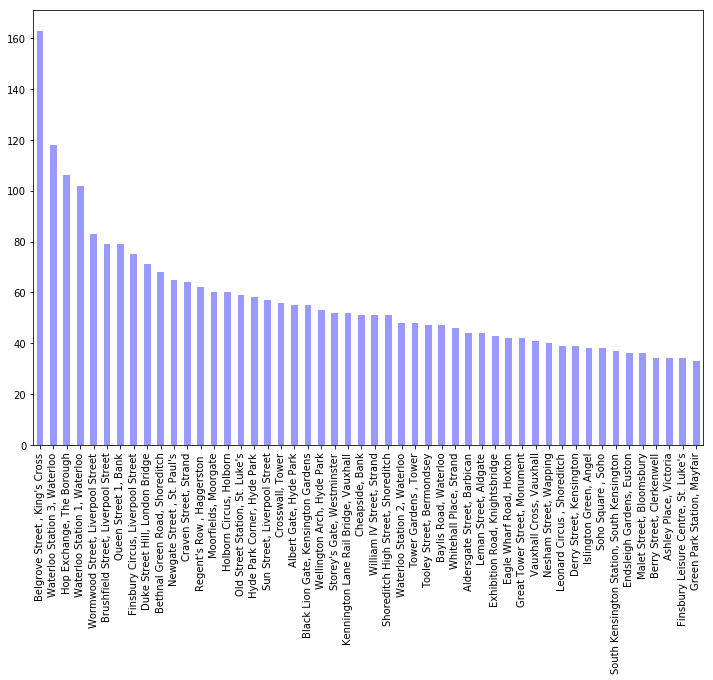

In [402]:
#get the degrees of each node and convert the dictionary to a dataframe
deg_df = pd.DataFrame(list(nx.degree(G).items()),columns=['station','degrees'])
#sort in descending order
deg_df = deg_df.sort_values(by='degrees',ascending=0)
#plot bar chart
ax = deg_df['degrees'].head(50).plot(kind='bar', color='b', alpha=0.4,figsize=(12,8))
ax.set_xticklabels(deg_df['station'].head(50));

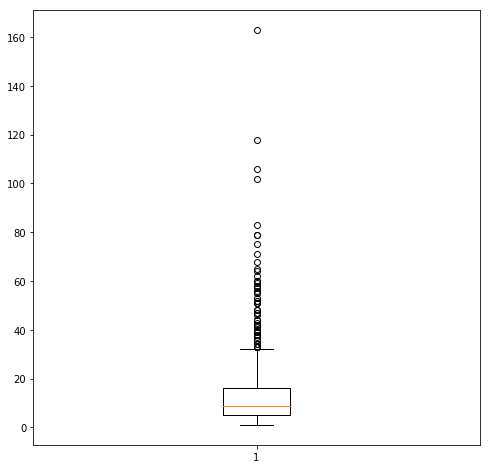

In [403]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.boxplot(deg_df['degrees']);

In [351]:
#get betweenness centrality for each node and convert the resulting dictionary to a dataframe
bc_df = pd.DataFrame(list(nx.betweenness_centrality(G).items()),columns=['station','betweenness-centrality'])
#sort in decreasing order
bc_df = bc_df.sort_values(by='betweenness-centrality',ascending=0)
#plot barchart
ax = bc_df['betweenness-centrality'].head(50).plot(kind='bar', color='b', alpha=0.4,figsize=(12,8))
ax.set_xticklabels(bc_df['station'].head(50));

KeyboardInterrupt: 

In [283]:
weather = pd.read_csv('weather/london_weather.csv',parse_dates=['date'],
                     dayfirst=True,infer_datetime_format=True)

In [296]:
weather.head()

,date,precipitation,mean_temp
0,2016-01-01,2.82,6.15
1,2016-01-02,4.41,7.18
2,2016-01-03,7.45,7.48
3,2016-01-04,0.92,8.32
4,2016-01-05,1.45,8.48


In [286]:
frame['start_date_date']=frame['start_date'].dt.date

In [298]:
frame['start_date_date']=pd.to_datetime(frame['start_date_date'])

In [305]:
rides_per_day = pd.DataFrame(frame.groupby('start_date_date').size().reset_index(name='rides'))

,start_date_date,rides
0,2015-12-25,22423
1,2015-12-26,10230
2,2015-12-27,9378
3,2015-12-28,13731
4,2015-12-29,15592


In [307]:
hires_with_weather = pd.merge(rides_per_day, weather, how='inner', left_on=['start_date_date'], right_on=['date'])

In [311]:
hires_with_weather = hires_with_weather[['date','rides','mean_temp','precipitation']]
hires_with_weather.head()

,date,rides,mean_temp,precipitation
0,2016-01-01,9797,6.15,2.82
1,2016-01-02,7195,7.18,4.41
2,2016-01-03,4869,7.48,7.45
3,2016-01-04,20532,8.32,0.92
4,2016-01-05,22804,8.48,1.45


In [342]:
hires_with_weather['weekday']=hires_with_weather['date'].dt.dayofweek<5

In [315]:
hires_with_weather.dtypes

date             datetime64[ns]
rides                     int64
mean_temp               float64
precipitation           float64
weekday                    bool
dtype: object

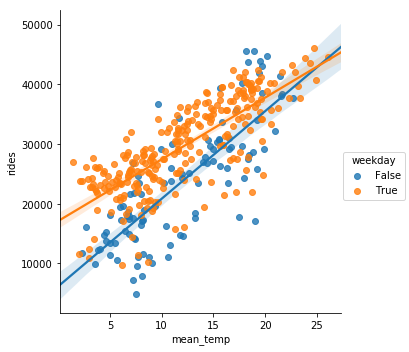

In [343]:
slope, intercept, r_value, p_value, std_err = stats.linregress(hires_with_weather['mean_temp'],hires_with_weather['rides'])

# use line_kws to set line label for legend
ax = sns.lmplot(x="mean_temp", y="rides", data=hires_with_weather, 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)},hue="weekday")



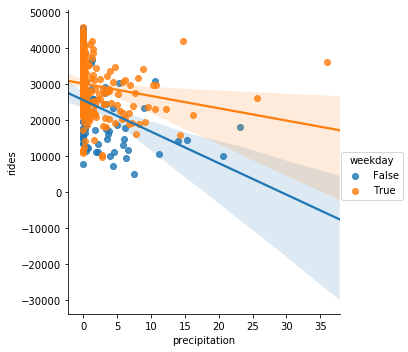

In [346]:
slope, intercept, r_value, p_value, std_err = stats.linregress(hires_with_weather['precipitation'],hires_with_weather['rides'])

# use line_kws to set line label for legend
ax = sns.lmplot(x="precipitation", y="rides", data=hires_with_weather, 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)},hue="weekday")

# plot legend
#ax.legend()